# Catchment delineation

We start our workflow by downloading all the static data we need. In this notebook we will...

1. ...download a **Digital Elevation Model** (DEM) for hydrologic applications,

2. ...**delineate the catchment** and determine the **catchment area** using your reference position (e.g. the location of your gauging station) as the "pouring point",

3. ...identify all glaciers within the catchment and download the **glacier outlines and ice thicknesses**,

4. ...create a glacier profile based on elevation zones.


First of all, we will read some settings from the `config.ini` file:

- **cloud project** name for the GEE access
- **input/output** folders for data imports and downloads
- **filenames** (DEM, GeoPackage)
- **coordinates** of the defined "pouring" point (Lat/Long)
- chosen **DEM** from GEE data catalog
- **show/hide GEE map** in notebooks

In [1]:
import pandas as pd
import numpy as np
import configparser
import ast
import matplotlib.pyplot as plt
import scienceplots

# read local config.ini file
config = configparser.ConfigParser()
config.read('config.ini')

# get file config from config.ini
cloud_project = config['CONFIG']['CLOUD_PROJECT']
output_folder = config['FILE_SETTINGS']['DIR_OUTPUT']
figures_folder = config['FILE_SETTINGS']['DIR_FIGURES']
filename = output_folder + config['FILE_SETTINGS']['DEM_FILENAME']
output_gpkg = output_folder + config['FILE_SETTINGS']['GPKG_NAME']

# get used GEE DEM, coords and other settings
dem_config = ast.literal_eval(config['CONFIG']['DEM'])
y, x = ast.literal_eval(config['CONFIG']['COORDS'])
show_map = config.getboolean('CONFIG', 'SHOW_MAP')

# get style for matplotlib plots
plt_style = ast.literal_eval(config['CONFIG']['PLOT_STYLE'])
plt.style.use(plt_style)

# print config data
print(f'Google Cloud Project : {cloud_project}')
print(f'DEM to download: {dem_config[3]}')
print(f'Coordinates of discharge point: Lat {y}, Lon {x}')

Google Cloud Project : huklima
DEM to download: MERIT 30m
Coordinates of discharge point: Lat 42.300264, Lon 78.091444


Now, the Google Earth Engine (GEE) access can be initialized. If this is the first time you run the notebook on this machine, you need to authenticate. When using <code>mybinder.org</code> you need to authenticate every time a new session has been launched. Follow the instructions on screen or see the guide in &rarr; [Notebook 0](Notebook0_Introduction.ipynb#Authorize-access-for-Google-Earth-Engine).

<div class="alert alert-block alert-info">
    <b>Note:</b> In order to make this work, the default cloud project in the <code>config.ini</code> 
    needs to be changed to your own. See the instructions in 
    <a href="Notebook0_Introduction.ipynb#signing-up-for-google-earth-engine-gee">Notebook 0</a>, step 5
    for details.
</div>


In [2]:
import ee

# initialize GEE at the beginning of session
try:
    ee.Initialize(project=cloud_project)
except Exception as e:
    ee.Authenticate()  # authenticate when using GEE for the first time
    ee.Initialize(project=cloud_project)


Successfully saved authorization token.


## Start GEE and download DEM

Once we are set up, we can start working with the data. Let's start with the **base map**, if enabled in `config.ini`. The map can be used to follow the steps as more layers are added throughout the notebook. <a id="map"></a>

In [3]:
import geemap

if show_map:
    Map = geemap.Map()
    display(Map)
else:
    print("Map view disabled in config.ini")

/Users/miajanzen/miniconda3/envs/matilda_edu/lib/python3.11/site-packages/geemap/conversion.py:23: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

Now we can download the DEM from the GEE catalog and add it as a new layer to the map. The default is the [MERIT DEM] (https://developers.google.com/earth-engine/datasets/catalog/MERIT_DEM_v1_0_3), but you can use any DEM available in the *Google Earth Engine Data Catalog* (https://developers.google.com/earth-engine/datasets/catalog) by specifying it in the `config.ini` file.


In [4]:
if dem_config[0] == 'Image':
    image = ee.Image(dem_config[1]).select(dem_config[2])
elif dem_config[0] == 'ImageCollection':
    image = ee.ImageCollection(dem_config[1]).select(dem_config[2]).mosaic()

if show_map:
    srtm_vis = {'bands': dem_config[2],
                'min': 0,
                'max': 6000,
                'palette': ['000000', '478FCD', '86C58E', 'AFC35E', '8F7131', 'B78D4F', 'E2B8A6', 'FFFFFF']
                }

    Map.addLayer(image, srtm_vis, dem_config[3], True, 0.7)

Next, we add the configured discharge point to the map and generate a **40km** buffer box. 

<div class="alert alert-block alert-info">
    <b>Note:</b> Please check whether the default box covers your research area. Alternatively, you can adjust the box manually. <b>The catchment area will be cropped if the selected box is too small.</b></div>

In [5]:
point = ee.Geometry.Point(x, y)
box = point.buffer(40000).bounds()

if show_map:
    Map.addLayer(point, {'color': 'blue'}, 'Discharge Point')
    Map.addLayer(box, {'color': 'grey'}, 'Catchment Area', True, 0.7)
    Map.centerObject(box, zoom=9)

The discharge point (marker) and box (polygon/rectangle) can also be added manually to the map above. If features have been drawn, they will overrule the configured discharge point and automatically created box.

<a id="rp01">**Restart Point #1**</a>

In [6]:
if show_map:
    for feature in Map.draw_features:
        f_type = feature.getInfo()['geometry']['type']
        if f_type == 'Point':
            point = feature.geometry()
            print("Manually set pouring point will be considered")
        elif f_type == 'Polygon':
            box = feature.geometry()
            print("Manually drawn box will be considered")

Now we can export the DEM as a `.tif` file for the selected extent to the output folder. Depending on the size of the selected area, this might take a while for processing and downloading.

In [7]:
import xarray as xr

download_xr = config.getboolean('CONFIG', 'GEE_DOWNLOAD_XR')

if download_xr:
    # new method using Xarray (supports larger areas)
    try:
        print('Get GEE data as Xarray...')
        ic = ee.ImageCollection(image)
        ds = xr.open_dataset(
            ic,
            engine='ee',
            projection=ic.first().select(0).projection(),
            geometry=box
        )

        print('Prepare Xarray for GeoTiff conversion...')
        ds_t = ds.isel(time=0).drop_vars("time").transpose()
        ds_t.rio.set_spatial_dims("lon", "lat", inplace=True)

        print('Save DEM as GeoTiff...')
        ds_t.rio.to_raster(filename)
        print('DEM successfully saved at', filename)
    except:
        print('Error during Xarray routine. Try direct download from GEE...')
        geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)
else:
    # old method using GEE API to download .tif directly
    geemap.ee_export_image(image, filename=filename, scale=30, region=box, file_per_band=False)

Get GEE data as Xarray...
Prepare Xarray for GeoTiff conversion...
Save DEM as GeoTiff...
DEM successfully saved at output/dem_gee.tif


## Catchment deliniation

Based on the downloaded DEM file, we can calculate a catchment area using the <code>pysheds</code> library. The result will be a raster and displayed at the end of this section.

The full documentation of the <code>pysheds</code> module can be found [here](https://mattbartos.com/pysheds/).

<div class="alert alert-block alert-info">
<b>Note:</b> The catchment delineation involves several steps with large array operations and can take a moment.</div>

In [8]:
%%time

# GIS packages
from pysheds.grid import Grid
import fiona

# load DEM
DEM_file = filename
grid = Grid.from_raster(DEM_file)
dem = grid.read_raster(DEM_file)
print("DEM loaded.")

DEM loaded.
CPU times: user 1.26 s, sys: 233 ms, total: 1.5 s
Wall time: 1.96 s


In [9]:
%%time

# Fill depressions in DEM
print("Fill depressions in DEM...")
flooded_dem = grid.fill_depressions(dem)
# Resolve flats in DEM
print("Resolve flats in DEM...")
inflated_dem = grid.resolve_flats(flooded_dem)

# Specify directional mapping
# N    NE    E    SE    S    SW    W    NW
dirmap = (64, 128, 1, 2, 4, 8, 16, 32)
# Compute flow directions
print("Compute flow directions...")
fdir = grid.flowdir(inflated_dem, dirmap=dirmap)
# catch = grid.catchment(x=x, y=y, fdir=fdir, dirmap=dirmap, xytype='coordinate')
# Compute accumulation
print("Compute accumulation...")
acc = grid.accumulation(fdir)
# Snap pour point to high accumulation cell
x_snap, y_snap = grid.snap_to_mask(acc > 1000, (x, y))
# Delineate the catchment
print("Delineate the catchment...")
catch = grid.catchment(x=x_snap, y=y_snap, fdir=fdir, xytype='coordinate')
# Clip the DEM to the catchment
print("Clip the DEM to the catchment...")
grid.clip_to(catch)
clipped_catch = grid.view(catch)
print("Processing completed.")

Fill depressions in DEM...
Resolve flats in DEM...
Compute flow directions...
Compute accumulation...
Delineate the catchment...
Clip the DEM to the catchment...
Processing completed.
CPU times: user 1.58 s, sys: 89.5 ms, total: 1.67 s
Wall time: 1.76 s


Now let's have a look at the catchment area.

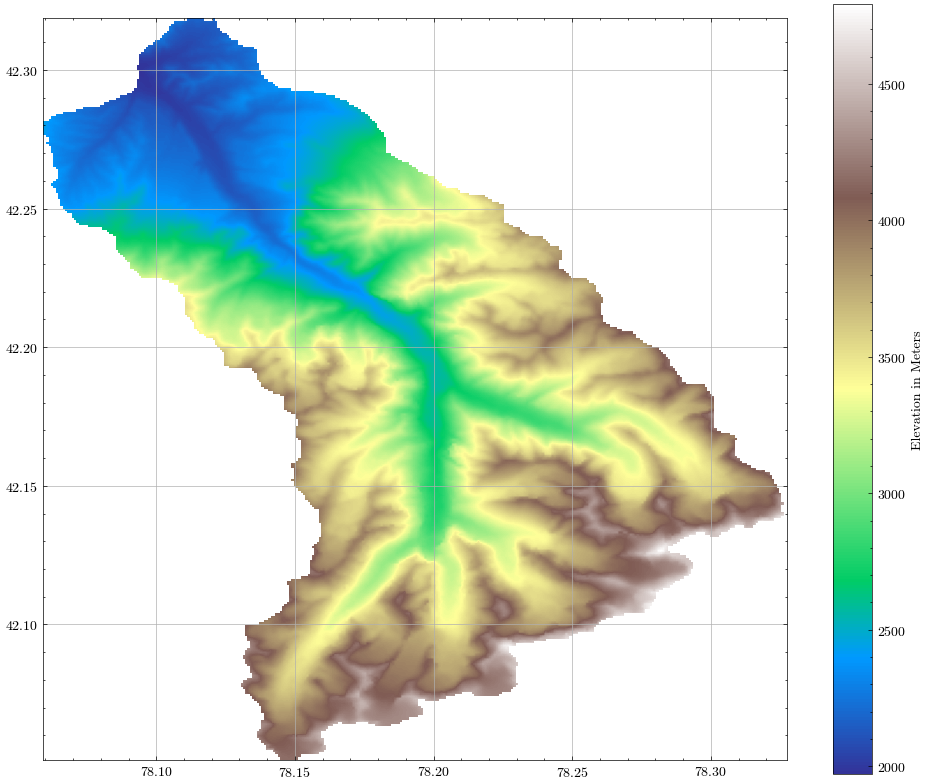

In [10]:
# Define a function to plot the digital elevation model
def plotFigure(data, label, cmap='Blues'):
    plt.figure(figsize=(12, 10))
    plt.imshow(data, extent=grid.extent, cmap=cmap)
    plt.colorbar(label=label)
    plt.grid()


demView = grid.view(dem, nodata=np.nan)
plotFigure(demView, 'Elevation in Meters', cmap='terrain')
plt.savefig(figures_folder + 'NB1_DEM_Catchment.png')
plt.show()

For the following steps we need the catchment outline as a polygon. Thus, we convert the **raster to a polygon** and save both in a **geopackage** to the output folder. From these files, we can already calculate important **catchment statistics** needed for the glacio-hydrological model in Notebook 4.

In [11]:
from shapely.geometry import Polygon, shape
from shapely.ops import transform
import pyproj

# Create shapefile and save it
shapes = grid.polygonize()

schema = {
    'geometry': 'Polygon',
    'properties': {'LABEL': 'float:16'}
}

catchment_shape = {}
layer_name = 'catchment_orig'
with fiona.open(output_gpkg, 'w',
                # driver='ESRI Shapefile',#
                driver='GPKG',
                layer=layer_name,
                crs=grid.crs.srs,
                schema=schema) as c:
    i = 0
    for shape, value in shapes:
        catchment_shape = shape
        rec = {}
        rec['geometry'] = shape
        rec['properties'] = {'LABEL': str(value)}
        rec['id'] = str(i)
        c.write(rec)
        i += 1

print(f"Layer '{layer_name}' added to GeoPackage '{output_gpkg}'\n")

catchment_bounds = [int(np.nanmin(demView)), int(np.nanmax(demView))]
ele_cat = float(np.nanmean(demView))
print(f"Catchment elevation ranges from {catchment_bounds[0]} m to {catchment_bounds[1]} m.a.s.l.")
print(f"Mean catchment elevation is {ele_cat:.2f} m.a.s.l.")

Layer 'catchment_orig' added to GeoPackage 'output/catchment_data.gpkg'

Catchment elevation ranges from 1970 m to 4791 m.a.s.l.
Mean catchment elevation is 3274.68 m.a.s.l.


We can also add the catchment polygon to the interactive map. This sends it to GEE and allows us to use a GEE function to calculate its area. Please scroll up to see the results on the map.

In [12]:
catchment = ee.Geometry.Polygon(catchment_shape['coordinates'])
if show_map:
    Map.addLayer(catchment, {}, 'Catchment')

catchment_area = catchment.area().divide(1000 * 1000).getInfo()
print(f"Catchment area is {catchment_area:.2f} km²")

Catchment area is 301.37 km²


<div class="alert alert-block alert-warning">
<b>Note:</b>
 Please make sure to leave some buffer between the catchment outline and the used box (&rarr; <a href='#map'>Jump to map</a>). If the bounding box is close to the catchment, please extent the box and repeat the DEM download and catchment delineation (&rarr; use <a href='#rp01'>Restart Point #1</a>).</div>

Example:

1. The automatically created box for the pouring point (in gray) is not sufficient to cover the entire catchment area; cropped at the eastern edge.
2. Manually drawn box (in blue) has been added to ensure that the catchment is not cropped &rarr; buffer remains on all edges

![Example for Cropped Catchment](images/gee_catchment_extent.png)

___

## Determine glaciers in catchment area

To acquire outlines of all glaciers in the catchment we will rely on latest Randolph Glacier Inventory (RGI 6.0).

> The *Randolph Glacier Inventory (RGI 6.0)* is a global inventory of glacier outlines. It is supplemental to the Global Land Ice Measurements from Space initiative (GLIMS). Production of the RGI was motivated by the Fifth Assessment Report of the Intergovernmental Panel on Climate Change (IPCC AR5). Future updates will be made to the RGI and the GLIMS Glacier Database in parallel during a transition period. As all these data are incorporated into the GLIMS Glacier Database and as download tools are developed to obtain GLIMS data in the RGI data format, the RGI will evolve into a downloadable subset of GLIMS, offering complete one-time coverage, version control, and a standard set of attributes.
>
> Source: https://www.glims.org/RGI/

The RGI dataset is divided into 19 so called *first-order regions*.

> RGI regions were developed under only three constraints: that they should resemble commonly recognized glacier domains, that together they should contain all of the world’s glaciers, and that their boundaries should be simple and readily recognizable on a map of the world.
>
> Source: [Pfeffer et.al. 2014](https://doi.org/10.3189/2014jog13j176)

![Map of the RGI regions; the red dots indicate the glacier locations and the blue circles the location of the 254 reference WGMS glaciers used by the OGGM calibration](https://docs.oggm.org/en/v1.2.0/_images/wgms_rgi_map.png)

In the first step, the RGI region of the catchment area must be determined to access the correct repository. Therefore, the RGI region outlines will be downloaded from the official website and joined with the catchment outline.

> Source: [RGI Consortium (2017)](https://doi.org/10.7265/4m1f-gd79)

In [16]:
import geopandas as gpd

# load catcment and RGI regions as DF
catchment = gpd.read_file(output_gpkg, layer='catchment_orig')
df_regions = gpd.read_file('https://www.gtn-g.ch/database/GlacReg_2017.zip', layer='GTN-G_glacier_regions_201707')
display(df_regions)

,FULL_NAME,RGI_CODE,WGMS_CODE,geometry
0,Alaska,1,ALA,"POLYGON ((-133 54.5, -134 54.5, -134 54, -134 ..."
1,Alaska,1,ALA,"POLYGON ((180 50, 179 50, 178 50, 177 50, 176 ..."
2,Western Canada and USA,2,WNA,"POLYGON ((-133 54.5, -132 54.5, -131 54.5, -13..."
3,"Arctic Canada, North",3,ACN,"POLYGON ((-125 74, -125 75, -125 76, -125 77, ..."
4,"Arctic Canada, South",4,ACS,"POLYGON ((-90 74, -89 74, -88 74, -87 74, -86 ..."
5,Greenland Periphery,5,GRL,"POLYGON ((-75 77, -74.73 77.51, -74.28 78.06, ..."
6,Iceland,6,ISL,"POLYGON ((-26 59, -26 60, -26 61, -26 62, -26 ..."
7,Svalbard and Jan Mayen,7,SJM,"POLYGON ((-10 70, -10 71, -10 72, -10 73, -10 ..."
8,Scandinavia,8,SCA,"POLYGON ((4 70, 4 71, 4 72, 4 73, 4 74, 5 74, ..."
9,Russian Arctic,9,RUA,"POLYGON ((35 70, 35 71, 35 72, 35 73, 35 74, 3..."


For spatial calculations it is crucial to use the correct projection. To avoid inaccuracies due to unit conversions we will project the data to UTM whenever we calculate spatial statistics. The relevant UTM zone and band for the catchment area are determined from the coordinates of the pouring point.

In [17]:
import utm
from pyproj import CRS

utm_zone = utm.from_latlon(y, x)
print(f"UTM zone '{utm_zone[2]}', band '{utm_zone[3]}'")

# get CRS based on UTM
crs = CRS.from_dict({'proj': 'utm', 'zone': utm_zone[2], 'south': False})

catchment_area = catchment.to_crs(crs).area[0] / 1000 / 1000
print(f"Catchment area (projected) is {catchment_area:.2f} km²")

UTM zone '44', band 'T'
Catchment area (projected) is 302.00 km²


Now we can perform a spatial join between the catchment outline and the RGI regions. If the catchment contains any glaciers, the corresponding RGI region is determined in this step.

In [18]:
df_regions = df_regions.set_crs('EPSG:4326', allow_override=True)
catchment = catchment.to_crs('EPSG:4326')
df_regions_catchment = gpd.sjoin(df_regions, catchment, how="inner", predicate="intersects")

if len(df_regions_catchment.index) == 0:
    print('No area found for catchment')
    rgi_region = None
elif len(df_regions_catchment.index) == 1:
    rgi_region = df_regions_catchment.iloc[0]['RGI_CODE']
    print(f"Catchment belongs to RGI region {rgi_region} ({df_regions_catchment.iloc[0]['FULL_NAME']})")
else:
    print("Catchment belongs to more than one region. This use case is not yet supported.")
    display(df_regions_catchment)
    rgi_region = None

Catchment belongs to RGI region 13 (Asia, Central)


In [33]:
rgi_code = int(df_regions_catchment['RGI_CODE'].iloc[0])
print(rgi_code)

13


In the next step, the glacier inventory outlines for the determined RGI region will be downloaded. A spatial join is performed to determine all glacier outlines that intersect with the catchment area.

<div class="alert alert-block alert-info">
<b>Note:</b>
 Depending on the region and bandwidth, this might take 1 min or longer.</div>

In [ ]:
import requests


rgi_mapping = {
    'druid:bk044mm2896': '1',       # Alaska
    'druid:bx819rp9942': '2',       # Western Canada and USA
    'druid:rf996wm9813': '3',       # Arctic Canada North
    'druid:jf736np7986': '4',       # Arctic Canada South
    'druid:jf791qw8489': '4',       # Greenland
    'druid:vw279vy3622': '6',       # Iceland
    'druid:vq951pn6443': '7',       # Svalbard Region
    'druid:xq220vs7286': '8',       # Scandinavia
    'druid:jg462fq0330': '9',       # Russian Arctic
    'druid:pd870md4737': '10',      # North Asia
    'druid:yk055mq6325': '11',      # Central Europe
    'druid:hq068pk2038': '12',      # Caucasus and Middle East
    'druid:tz454nz3540': '13',      # Central Asia
    'druid:kh918qf4828': '14',      # South West Asia
    'druid:nf183jx2059': '15',      # South East Asia
    'druid:rb597mv0151': '16',      # Low Latitudes
    'druid:jp070dq9346': '17',      # Southern Andes
    'druid:zv495xg4344': '18',      # New Zealand
    'druid:gg131xy9972': '19'       # Antarctic and Sub-Antarctic
}


geoserver_url = "https://geowebservices.stanford.edu/geoserver/wfs?"
rgi_code = int(df_regions_catchment['RGI_CODE'].iloc[0])
type_name = next((k for k, v in rgi_mapping.items() if v == str(rgi_code)), None)

print(type_name)
if not type_name:
    print(f"RGI region {rgi_code} not found in mapping.")


params = {
    'service': 'WFS',
    'version': '2.0.0',
    'request': 'GetFeature',
    'typeName': type_name,
    'outputFormat': 'application/json'
}

response = requests.get(geoserver_url, params=params)
    
print('Loading shapefiles...')
rgi = gpd.read_file(response.text)

if rgi.crs != catchment.crs:
    print("CRS adjusted")
    catchment = catchment.to_crs(rgi.crs)

# check whether catchment intersects with glaciers of region
print('Perform spatial join...')
rgi_catchment = gpd.sjoin(rgi, catchment, how='inner', predicate='intersects')
if len(rgi_catchment.index) > 0:
    print(f'{len(rgi_catchment.index)} outlines loaded from RGI Region {rgi_code}\n')

druid:tz454nz3540
Loading shapefiles...
              id           rgiid         glimsid rgiflag   bgndate   enddate  \
0  tz454nz3540.1  RGI50-13.00001  G079494E34471N    0909  20000810  -9999999   
1  tz454nz3540.2  RGI50-13.00002  G077951E35545N    0909  20020802  -9999999   
2  tz454nz3540.3  RGI50-13.00003  G077930E35519N    0909  20020802  -9999999   
3  tz454nz3540.4  RGI50-13.00004  G077924E35525N    0909  20020802  -9999999   
4  tz454nz3540.5  RGI50-13.00005  G077914E35531N    0909  20020802  -9999999   

    cenlon   cenlat o1region o2region   area  zmin  zmax  zmed  slope  aspect  \
0  79.4939  34.4713       13        5  0.432  5678  5928  5763   22.0     312   
1  77.9513  35.5452       13        5  0.367  5889  6217  6051   25.4     195   
2  77.9295  35.5188       13        5  0.070  5646  5849  5756   27.3     318   
3  77.9237  35.5252       13        5  0.255  5698  5850  5756   16.9      39   
4  77.9141  35.5309       13        5  0.261  5644  5809  5745   19.0     

Some glaciers are not actually in the catchment, but intersect its outline. We will first determine their fractional overlap with the target catchment.

In [44]:
# intersects selects too many. calculate percentage of glacier area that is within catchment
rgi_catchment['rgi_area'] = rgi_catchment.to_crs(crs).area

gdf_joined = gpd.overlay(catchment, rgi_catchment, how='union')
gdf_joined['area_joined'] = gdf_joined.to_crs(crs).area
gdf_joined['share_of_area'] = (gdf_joined['area_joined'] / gdf_joined['rgi_area'] * 100)

results = (gdf_joined
           .groupby(['rgiid', 'LABEL_1'])
           .agg({'share_of_area': 'sum'}))

display(results.sort_values(['share_of_area'], ascending=False))

,,share_of_area
rgiid,LABEL_1,
RGI50-13.06361,1.0,100.000000
RGI50-13.07719,1.0,100.000000
RGI50-13.06374,1.0,100.000000
RGI50-13.06356,1.0,100.000000
RGI50-13.06357,1.0,100.000000
RGI50-13.06358,1.0,100.000000
RGI50-13.06381,1.0,100.000000
RGI50-13.06380,1.0,100.000000
RGI50-13.06366,1.0,100.000000


Now we can **filter** based on the percentage of shared area. After that the catchment area will be adjusted as follows:

- **&#8805;50%** of the area are in the catchment &rarr; **include** and extend catchment area by full glacier outlines (if needed)
- **<50%** of the area are in the catchment &rarr; **exclude** and reduce catchment area by glacier outlines (if needed)

In [46]:
rgi_catchment_merge = pd.merge(rgi_catchment, results, on="rgiid")
rgi_in_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] >= 50]
rgi_out_catchment = rgi_catchment_merge.loc[rgi_catchment_merge['share_of_area'] < 50]
catchment_new = gpd.overlay(catchment, rgi_out_catchment, how='difference')
catchment_new = gpd.overlay(catchment_new, rgi_in_catchment, how='union')
catchment_new = catchment_new.dissolve()[['LABEL_1', 'geometry']]

print(f'Total number of determined glacier outlines: {len(rgi_catchment_merge)}')
print(f'Number of included glacier outlines (overlap >= 50%): {len(rgi_in_catchment)}')
print(f'Number of excluded glacier outlines (overlap < 50%): {len(rgi_out_catchment)}')

Total number of determined glacier outlines: 51
Number of included glacier outlines (overlap >= 50%): 38
Number of excluded glacier outlines (overlap < 50%): 13


The RGI-IDs of the remaining glaciers are stored in `Glaciers_in_catchment.csv`.

In [49]:
from pathlib import Path

Path(output_folder + 'RGI').mkdir(parents=True, exist_ok=True)

glacier_ids = pd.DataFrame(rgi_in_catchment)
glacier_ids['rgiid'] = glacier_ids['rgiid'].map(lambda x: str(x).lstrip('RGI60-'))
glacier_ids.to_csv(output_folder + 'RGI/' + 'Glaciers_in_catchment.csv', columns=['rgiid', 'glimsid'], index=False)
display(glacier_ids)

,id,rgiid,glimsid,rgiflag,bgndate,enddate,cenlon,cenlat,o1region,o2region,...,slope,aspect,lmax,glactype,name,geometry,index_right,LABEL,rgi_area,share_of_area
0,tz454nz3540.6357,50-13.06357,G078259E42209N,0909,20020825,-9999999,78.258704,42.209002,13,3,...,25.2,258,359,0099,None,"MULTIPOLYGON (((78.2596 42.20812, 78.25958 42....",0,1.0,5.305510e+04,100.000000
1,tz454nz3540.6358,50-13.06358,G078286E42186N,0909,20020825,-9999999,78.285595,42.185778,13,3,...,23.0,334,401,0099,None,"MULTIPOLYGON (((78.28462 42.18393, 78.28461 42...",0,1.0,8.178841e+04,100.000000
2,tz454nz3540.6353,50-13.06353,G078245E42230N,0909,20020825,-9999999,78.245360,42.230246,13,3,...,22.5,337,497,0099,None,"MULTIPOLYGON (((78.2473 42.22858, 78.24725 42....",0,1.0,1.224364e+05,70.494609
3,tz454nz3540.6354,50-13.06354,G078260E42217N,0909,20020825,-9999999,78.259558,42.216524,13,3,...,16.7,348,1141,0099,None,"MULTIPOLYGON (((78.25962 42.21159, 78.25962 42...",0,1.0,2.689387e+05,90.109653
4,tz454nz3540.6355,50-13.06355,G078253E42212N,0909,20020825,-9999999,78.252936,42.211929,13,3,...,28.2,331,736,0099,None,"MULTIPOLYGON (((78.25481 42.2114, 78.25437 42....",0,1.0,1.772687e+05,100.000000
5,tz454nz3540.6356,50-13.06356,G078242E42208N,0909,20020825,-9999999,78.241914,42.207501,13,3,...,18.9,1,950,0099,None,"MULTIPOLYGON (((78.24325 42.20383, 78.24278 42...",0,1.0,3.976881e+05,100.000000
6,tz454nz3540.6359,50-13.06359,G078305E42146N,0909,20020825,-9999999,78.304754,42.146142,13,3,...,20.0,336,3864,0091,Karabatkak Glacier,"MULTIPOLYGON (((78.30373 42.14478, 78.30374 42...",0,1.0,4.202605e+06,99.707637
7,tz454nz3540.6360,50-13.06360,G078285E42147N,0909,20020825,-9999999,78.284766,42.146579,13,3,...,33.7,42,951,0099,None,"MULTIPOLYGON (((78.2866 42.14613, 78.2866 42.1...",0,1.0,2.530300e+05,100.000000
8,tz454nz3540.6361,50-13.06361,G078273E42140N,0909,20020825,-9999999,78.272803,42.140310,13,3,...,21.2,358,3378,0099,None,"MULTIPOLYGON (((78.27549 42.13342, 78.27502 42...",0,1.0,2.047230e+06,100.000000
9,tz454nz3540.6371,50-13.06371,G078177E42081N,0909,20020825,-9999999,78.177069,42.081380,13,3,...,33.6,99,528,0099,None,"MULTIPOLYGON (((78.17566 42.08282, 78.17543 42...",0,1.0,7.865743e+04,100.000000


With an updated glacier outline we can now determine the **final area of the catchment** and the **part covered by glaciers**.

In [50]:
catchment_new['area'] = catchment_new.to_crs(crs)['geometry'].area
area_glac = rgi_in_catchment.to_crs(crs)['geometry'].area

area_glac = area_glac.sum() / 1000000
area_cat = catchment_new.iloc[0]['area'] / 1000000
cat_cent = catchment_new.to_crs(crs).centroid
lat = cat_cent.to_crs('EPSG:4326').y[0]

print(f"New catchment area is {area_cat:.2f} km²")
print(f"Glacierized catchment area is {area_glac:.2f} km²")

New catchment area is 300.66 km²
Glacierized catchment area is 31.83 km²


The files just created are added to the existing geopackage...

In [51]:
rgi_in_catchment.to_file(output_gpkg, layer='rgi_in', driver='GPKG')
print(f"Layer 'rgi_in' added to GeoPackage '{output_gpkg}'")

rgi_out_catchment.to_file(output_gpkg, layer='rgi_out', driver='GPKG')
print(f"Layer 'rgi_out' added to GeoPackage '{output_gpkg}'")

catchment_new.to_file(output_gpkg, layer='catchment_new', driver='GPKG')
print(f"Layer 'catchment_new' added to GeoPackage '{output_gpkg}'")

Layer 'rgi_in' added to GeoPackage 'output/catchment_data.gpkg'
Layer 'rgi_out' added to GeoPackage 'output/catchment_data.gpkg'
Layer 'catchment_new' added to GeoPackage 'output/catchment_data.gpkg'


...and can also be added to the interactive map...

In [52]:
c_new = geemap.geopandas_to_ee(catchment_new)
rgi = geemap.geopandas_to_ee(rgi_in_catchment)

if show_map:
    Map.addLayer(c_new, {'color': 'orange'}, "Catchment New")
    Map.addLayer(rgi, {'color': 'white'}, "RGI60")
    print('New layers added.')

New layers added.


&rarr; [Jump to map](#map) to see the results.

...or combined in a simple plot.

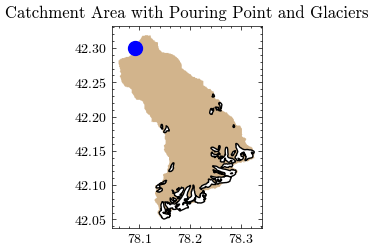

In [53]:
fig, ax = plt.subplots()
catchment_new.plot(color='tan', ax=ax)
rgi_in_catchment.plot(color="white", edgecolor="black", ax=ax)
plt.scatter(x, y, facecolor='blue', s=100)
plt.title("Catchment Area with Pouring Point and Glaciers")
plt.savefig(figures_folder + 'NB1_Glaciers_Catchment.png')
plt.show()

After adding the new catchment area to GEE, we can easily calculate the mean catchment elevation in meters above sea level.

In [54]:
ele_cat = image.reduceRegion(ee.Reducer.mean(),
                             geometry=c_new).getInfo()[dem_config[2]]
print(f"Mean catchment elevation (adjusted) is {ele_cat:.2f} m a.s.l.")

Mean catchment elevation (adjusted) is 3271.90 m a.s.l.


### Interim Summary:

So far we have...

- ...delineated the catchment and determined its area,

- ...calculated the average elevation of the catchment,

- ...identified the glaciers in the catchment and calculated their combined area.

In the next step, we will create a glacier profile to determine how the ice is distributed over the elevation range.
___

## Retrieve ice thickness rasters and corresponding DEM files

Determining ice thickness from remotely sensed data is a challenging task. Fortunately, [Farinotti et.al. (2019)](https://doi.org/10.1038/s41561-019-0300-3) calculated an ensemble estimate of different methods for all glaciers in RGI6 and made the data available [to the public](https://www.research-collection.ethz.ch/handle/20.500.11850/315707).

The published repository contains...

> (a) the **ice thickness distribution** of individual glaciers,<br/>
> (b) global grids at various resolutions with **summary-information about glacier number, area, and volume**, and<br/>
> (c) the **digital elevation models** of the glacier surfaces used to produce the estimates.
>
> Nomenclature for glaciers and regions follows the Randolph Glacier Inventory (RGI) version 6.0.
>
> Source: Farinotti et.al. 2019 - [README](https://www.research-collection.ethz.ch/bitstream/handle/20.500.11850/315707/README.txt)

The **ice thickness rasters (a)** and **aligned DEMs (c)** are the perfect input data for our glacier profile. The files are selected and downloaded by their **RGI IDs** and stored in the output folder.

Since the original files hosted by ETH Zurich are stored in large archives, we cut the dataset into smaller slices and reupload them according to the respective [license](https://creativecommons.org/licenses/by-nc-sa/4.0/) to make them searchable, improve performance, and limit traffic.

First, we identify the relevant archives for our set of glacier IDs.

In [57]:
def getArchiveNames(row):
    region = row['rgiid'].split('.')[0]
    id = (int(row['rgiid'].split('.')[1]) - 1) // 1000 + 1
    return f'ice_thickness_{region}_{id}', f'dem_surface_DEM_{region}_{id}'


# determine relevant .zip files for derived RGI IDs
df_rgiids = pd.DataFrame(rgi_in_catchment['rgiid'].sort_values())
df_rgiids[['thickness', 'dem']] = df_rgiids.apply(getArchiveNames, axis=1, result_type='expand')
zips_thickness = df_rgiids['thickness'].drop_duplicates()
zips_dem = df_rgiids['dem'].drop_duplicates()

print(f'Thickness archives:\t{zips_thickness.tolist()}')
print(f'DEM archives:\t\t{zips_dem.tolist()}')

Thickness archives:	['ice_thickness_RGI50-13_7', 'ice_thickness_RGI50-13_8']
DEM archives:		['dem_surface_DEM_RGI50-13_7', 'dem_surface_DEM_RGI50-13_8']


The archives are stored on a file server at the Humboldt University of Berlin, which provides limited read access to this notebook. The corresponding credentials and API key are defined in the `config.ini` file. The next step is to identify the corresponding resource references for the previously identified archives.

In [64]:
from resourcespace import ResourceSpace

# use guest credentials to access media server
api_base_url = config['MEDIA_SERVER']['api_base_url']
private_key = config['MEDIA_SERVER']['private_key']
user = config['MEDIA_SERVER']['user']

myrepository = ResourceSpace(api_base_url, user, private_key)

# get resource IDs for each .zip file
refs_thickness = pd.DataFrame(myrepository.get_collection_resources(12))[
    ['ref', 'file_size', 'file_extension', 'field8']]
refs_dem = pd.DataFrame(myrepository.get_collection_resources(21))[['ref', 'file_size', 'file_extension', 'field8']]

# reduce list of resources two required zip files
refs_thickness = pd.merge(zips_thickness, refs_thickness, left_on='thickness', right_on='field8')
refs_dem = pd.merge(zips_dem, refs_dem, left_on='dem', right_on='field8')

print(f'Thickness archive references:\n')
display(refs_thickness)
print(f'DEM archive references:\n')
display(refs_dem)

Thickness archive references:



,thickness,ref,file_size,file_extension,field8


DEM archive references:



,dem,ref,file_size,file_extension,field8


Again, depending on the number of files and bandwidth, this may take a moment. Let's start with the **ice thickness**...

In [59]:
%%time

import requests
from zipfile import ZipFile
import io

cnt_thickness = 0
file_names_thickness = []
for idx, row in refs_thickness.iterrows():
    content = myrepository.get_resource_file(row['ref'], row['file_extension'])
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['thickness'] == row['field8']]['RGIId']:
            filename = rgiid + '_thickness.tif'
            if filename in listOfFileNames:
                cnt_thickness += 1
                zipObj.extract(filename, output_folder + 'RGI')
                file_names_thickness.append(filename)
            else:
                print(f'File not found: {filename}')

print(f'{cnt_thickness} files have been extracted (ice thickness)')

0 files have been extracted (ice thickness)
CPU times: user 272 μs, sys: 217 μs, total: 489 μs
Wall time: 530 μs


...and continue with the matching **DEMs**.

In [60]:
%%time

cnt_dem = 0
file_names_dem = []
for idx, row in refs_dem.iterrows():
    content = myrepository.get_resource_file(row['ref'])
    with ZipFile(io.BytesIO(content), 'r') as zipObj:
        # Get a list of all archived file names from the zip
        listOfFileNames = zipObj.namelist()
        for rgiid in df_rgiids.loc[df_rgiids['dem'] == row['field8']]['RGIId']:
            filename = f"surface_DEM_{rgiid}.tif"
            if filename in listOfFileNames:
                cnt_dem += 1
                zipObj.extract(filename, output_folder + 'RGI')
                file_names_dem.append(filename)
            else:
                print(f'File not found: {filename}')

print(f'{cnt_dem} files have been extracted (DEM)')

0 files have been extracted (DEM)
CPU times: user 113 μs, sys: 3 μs, total: 116 μs
Wall time: 117 μs


<div class="alert alert-block alert-warning">
<b>Note:</b>
 Please check whether all files have been extracted to the output folder without error messages and <b>the number of files matches the number of glaciers</b>.</div>

In [61]:
if len(rgi_in_catchment) == cnt_thickness == cnt_dem:
    print(f"Number of files matches the number of glaciers within catchment: {len(rgi_in_catchment)}")
else:
    print("There is a mismatch of extracted files. Please check previous steps for error messages!")
    print(f'Number of included glaciers:\t{len(rgi_in_catchment)}')
    print(f'Ice thickness files:\t\t{cnt_thickness}')
    print(f'DEM files:\t\t\t{cnt_dem}')

There is a mismatch of extracted files. Please check previous steps for error messages!
Number of included glaciers:	38
Ice thickness files:		0
DEM files:			0


## Glacier profile creation

The **glacier profile** is used to pass the distribution of ice mass in the catchment to the glacio-hydrological model in **Notebook 4**, following the approach of [Seibert et.al.2018](https://doi.org/10.5194/hess-22-2211-2018). The model then calculates the annual mass balance and redistributes the ice mass accordingly.

To derive the profile from spatially distributed data, we first stack the ice thickness and corresponding DEM rasters for each glacier and create tuples of ice thickness and elevation values.

In [63]:
from osgeo import gdal

df_all = pd.DataFrame()
if cnt_thickness != cnt_dem:
    print('Number of ice thickness raster files does not match number of DEM raster files!')
else:
    for idx, rgiid in enumerate(df_rgiids['rgiid']):
        if rgiid in file_names_thickness[idx] and rgiid in file_names_dem[idx]:
            file_list = [
                output_folder + 'RGI/' + file_names_thickness[idx],
                output_folder + 'RGI/' + file_names_dem[idx]
            ]
            array_list = []

            # Read arrays
            for file in file_list:
                src = gdal.Open(file)
                geotransform = src.GetGeoTransform()  # Could be done more elegantly outside the for loop
                projection = src.GetProjectionRef()
                array_list.append(src.ReadAsArray())
                pixelSizeX = geotransform[1]
                pixelSizeY = -geotransform[5]
                src = None

            df = pd.DataFrame()
            df['thickness'] = array_list[0].flatten()
            df['altitude'] = array_list[1].flatten()
            df_all = pd.concat([df_all, df])

        else:
            print(f'Raster files do not match for {rgiid}')

print("Ice thickness and elevations rasters stacked")
print("Value pairs created")

IndexError: list index out of range

Now we can remove all data points with zero ice thickness and aggregate all data points into 10m **elevation zones**. The next step is to calculate the **water equivalent** (WE) from the average ice thickness in each elevation zone.

The result is exported to the output folder as `glacier_profile.csv`.

In [ ]:
if len(df_all) > 0:
    df_all = df_all.loc[df_all['thickness'] > 0]
    df_all.sort_values(by=['altitude'], inplace=True)

    # get min/max altitude considering catchment and all glaciers
    alt_min = 10 * int(min(catchment_bounds[0], df_all['altitude'].min()) / 10)
    alt_max = max(catchment_bounds[1], df_all['altitude'].max()) + 10

    # create bins in 10m steps
    bins = np.arange(alt_min, df_all['altitude'].max() + 10, 10)

    # aggregate per bin and do some math
    df_agg = df_all.groupby(pd.cut(df_all['altitude'], bins))['thickness'].agg(count='size', mean='mean').reset_index()
    df_agg['Elevation'] = df_agg['altitude'].apply(lambda x: x.left).astype(int)
    df_agg['Area'] = df_agg['count'] * pixelSizeX * pixelSizeY / catchment_new.iloc[0]['area']
    df_agg['WE'] = df_agg['mean'] * 0.908 * 1000
    df_agg['EleZone'] = df_agg['Elevation'].apply(lambda x: 100 * int(x / 100))

    # delete empty elevation bands but keep at least one entry per elevation zone
    df_agg = pd.concat([df_agg.loc[df_agg['count'] > 0],
                        df_agg.loc[df_agg['count'] == 0].drop_duplicates(['EleZone'], keep='first')]
                       ).sort_index()

    df_agg.drop(['altitude', 'count', 'mean'], axis=1, inplace=True)
    df_agg = df_agg.replace(np.nan, 0)
    df_agg.to_csv(output_folder + 'glacier_profile.csv', header=True, index=False)
    print('Glacier profile for catchment created!\n')
    display(df_agg)

Let's visualize the glacier profile. First we aggregate the ice mass in larger elevation zones for better visibility. The level of aggregation can be adjusted using the variable `steps` (default is 20m).

In [ ]:
# aggregation level for plot -> feel free to adjust
steps = 20

# get elevation range where glaciers are present
we_range = df_agg.loc[df_agg['WE'] > 0]['Elevation']
we_range.min() // steps * steps
plt_zones = pd.Series(range(int(we_range.min() // steps * steps),
                            int(we_range.max() // steps * steps + steps),
                            steps), name='EleZone').to_frame().set_index('EleZone')

# calculate glacier mass and aggregate glacier profile to defined elevation steps
plt_data = df_agg.copy()
plt_data['EleZone'] = plt_data['Elevation'].apply(lambda x: int(x // steps * steps))
plt_data['Mass'] = plt_data['Area'] * catchment_new.iloc[0]['area'] * plt_data['WE'] * 1e-9  # mass in Mt
plt_data = plt_data.drop(['Area', 'WE'], axis=1).groupby('EleZone').sum().reset_index().set_index('EleZone')
plt_data = plt_zones.join(plt_data)
display(plt_data)

Now, we can plot the estimated **glacier mass (in Mt) for each elevation zone.**

In [ ]:
import matplotlib.ticker as ticker

fig, ax = plt.subplots(figsize=(4, 5))
plt_data.plot.barh(y='Mass', ax=ax)
ax.set_xlabel("Glacier mass [Mt]")
ax.set_yticks(ax.get_yticks()[::int(100 / steps)])
ax.set_ylabel("Elevation zone [m a.s.l.]")
ax.get_legend().remove()
plt.title("Initial Ice Distribution")
plt.tight_layout()
plt.savefig(figures_folder + 'NB1_Glacier_Mass_Elevation.png')
plt.show()

Finally, we calculate the average glacier elevation in meters above sea level.

In [ ]:
ele_glac = round(df_all.altitude.mean(), 2)
print(f'Average glacier elevation in the catchment: {ele_glac:.2f} m a.s.l.')

## Store calculated values for other notebooks

Create a `settings.yml` and store the relevant catchment information for the model setup:

- **area_cat**: area of the catchment in km²
- **ele_cat**: average elevation of the catchment in m.a.s.l.
- **area_glac**: glacier covered area as of 2000 in km²
- **ele_glac**: average elevation of glacier covered area in m.a.s.l.
- **lat**: latitude of catchment centroid

In [ ]:
import yaml

settings = {'area_cat': float(area_cat),
            'ele_cat': float(ele_cat),
            'area_glac': float(area_glac),
            'ele_glac': float(ele_glac),
            'lat': float(lat)
            }
with open(output_folder + 'settings.yml', 'w') as f:
    yaml.safe_dump(settings, f)

print('Settings saved to file.')
display(pd.DataFrame(settings.items(), columns=['Parameter', 'Value']).set_index('Parameter'))

You can now continue with [Notebook 2](Notebook2_Forcing_data.ipynb) or ...

## *Optional*: Download Outputs

<div class="alert alert-block alert-info">
<b>Note:</b>
 The output folder is zipped at the end of each notebook and can be downloaded (file <code>output_download.zip</code>). This is especially useful if you want to use the binder environment again, but don't want to start over from Notebook 1.</div>

<img src="images/download_output.png" width=300>


In [ ]:
import shutil

shutil.make_archive('output_download', 'zip', 'output')
print('Output folder can be download now (file output_download.zip)')

In [ ]:
%reset -f